<a href="https://colab.research.google.com/github/suhitaghosh10/colab_examples/blob/master/cifar_autoenc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import datasets
from imgaug import augmenters
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, UpSampling3D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
plt.gray()

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [0]:
## Download the data
(x_train, y_train), (x_val, y_val) = datasets.cifar10.load_data()

In [3]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


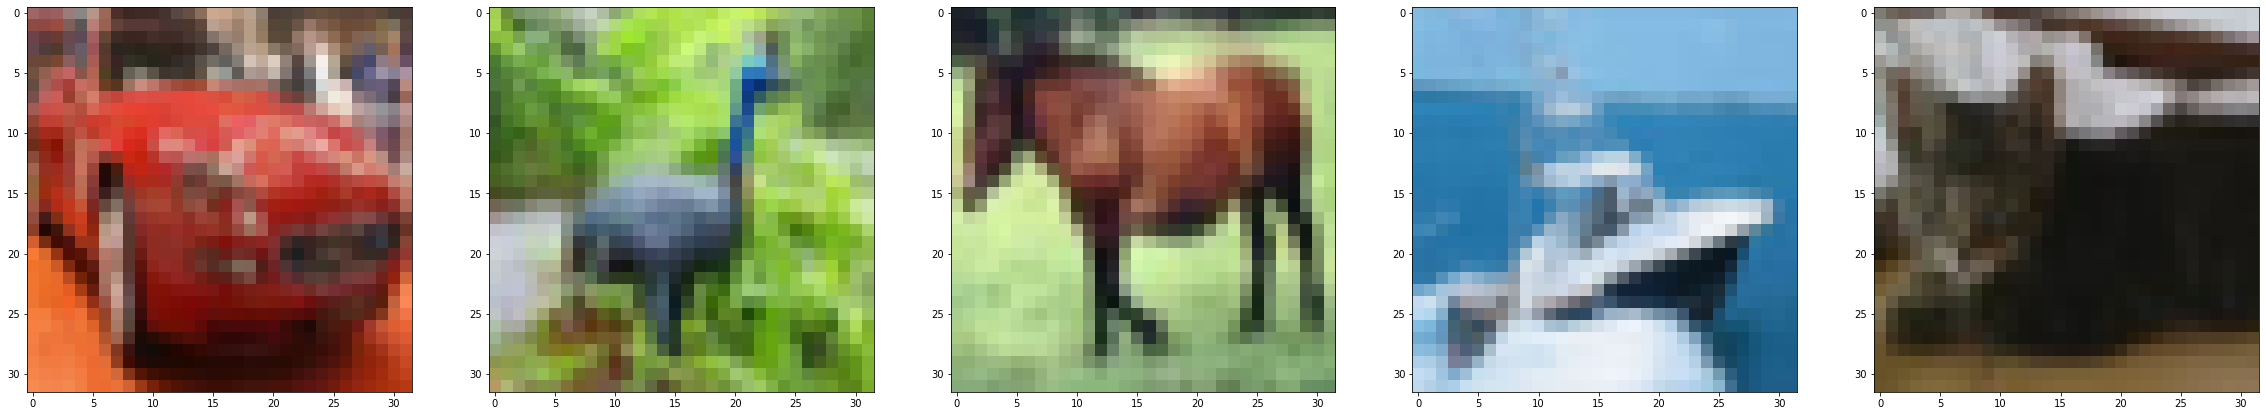

In [4]:
f, ax = plt.subplots(1,5)
f.set_size_inches(40, 20)
for i in range(5,10):
    ax[i-5].imshow(x_train[i].reshape(32, 32, 3))

In [5]:
x_train = x_train/255
x_val = x_val/255

x_train = x_train.reshape(-1,32,32,3)
x_val = x_val.reshape(-1,32,32,3)

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


In [0]:
#add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_obj = augmenters.Sequential([noise])

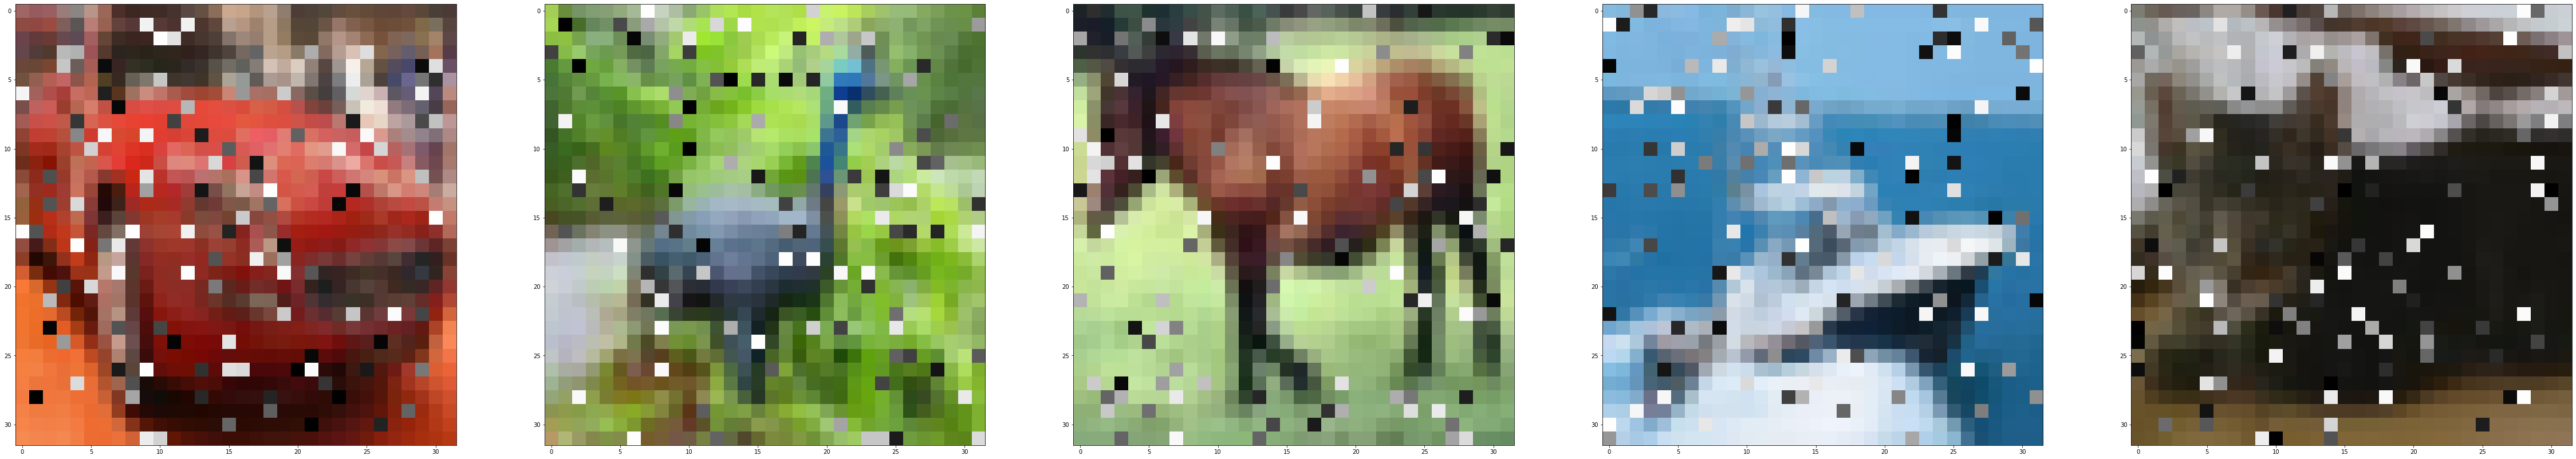

In [7]:
train_x_n = seq_obj.augment_images(x_train * 255) / 255
val_x_n = seq_obj.augment_images(x_val * 255) / 255
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(32, 32, 3))

In [0]:
train_x_n = train_x_n.reshape(-1,32,32,3, 1)
val_x_n = val_x_n.reshape(-1,32,32,3, 1)

In [37]:
clear_session()
# input layer

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))

#encoder
init_fltr=16
encoded_layer1 = Conv3D(init_fltr, (3, 3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool3D( (2, 2, 1), padding='same')(encoded_layer1)
encoded_layer2 = Conv3D(init_fltr*2, (3, 3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool3D( (2, 2, 1), padding='same')(encoded_layer2)
encoded_layer3 = Conv3D(init_fltr*4, (3, 3, 3), activation='relu', padding='same')(encoded_layer2)
latent    = MaxPool3D( (2, 2, 1), padding='same', name='latent1')(encoded_layer3)
# decoder
decoded_layer1 = Conv3D(init_fltr*4, (3, 3, 3), activation='relu', padding='same')(latent)
decoded_layer1 = UpSampling3D((2, 2, 1))(decoded_layer1)
decoded_layer2 = Conv3D(init_fltr*2, (3, 3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling3D((2, 2, 1))(decoded_layer2)
decoded_layer3 = Conv3D(init_fltr, (3, 3, 3), activation='relu', padding='same')(decoded_layer2)
decoded_layer3 = UpSampling3D((2, 2, 1))(decoded_layer3)
output_layer   = Conv3D(1, (3, 3, 3), padding='same', activation='sigmoid')(decoded_layer3)


# compile the model
model = Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 32, 32, 3, 16)     448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 16, 3, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 16, 3, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 3, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 3, 64)       55360     
_________________________________________________________________
latent1 (MaxPooling3D)       (None, 4, 4, 3, 64)       0     

In [38]:
model.compile(optimizer='adam', loss='mse')

# run the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
#just train for 5 epochs
history = model.fit(train_x_n, x_train, epochs=10, batch_size=2048, validation_data=(val_x_n, x_val), callbacks=[early_stopping])

Epoch 1/10
25/25 [==============================] - 11s 457ms/step - loss: 0.0619 - val_loss: 0.0495
Epoch 2/10
25/25 [==============================] - 11s 449ms/step - loss: 0.0441 - val_loss: 0.0319
Epoch 3/10
25/25 [==============================] - 11s 449ms/step - loss: 0.0274 - val_loss: 0.0235
Epoch 4/10
25/25 [==============================] - 11s 451ms/step - loss: 0.0221 - val_loss: 0.0198
Epoch 5/10
25/25 [==============================] - 11s 449ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 6/10
25/25 [==============================] - 11s 450ms/step - loss: 0.0170 - val_loss: 0.0195
Epoch 7/10
25/25 [==============================] - 11s 450ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 8/10
25/25 [==============================] - 11s 449ms/step - loss: 0.0151 - val_loss: 0.0158
Epoch 9/10
25/25 [==============================] - 11s 450ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 10/10
25/25 [==============================] - 11s 449ms/step - loss: 0.0142 - val_lo

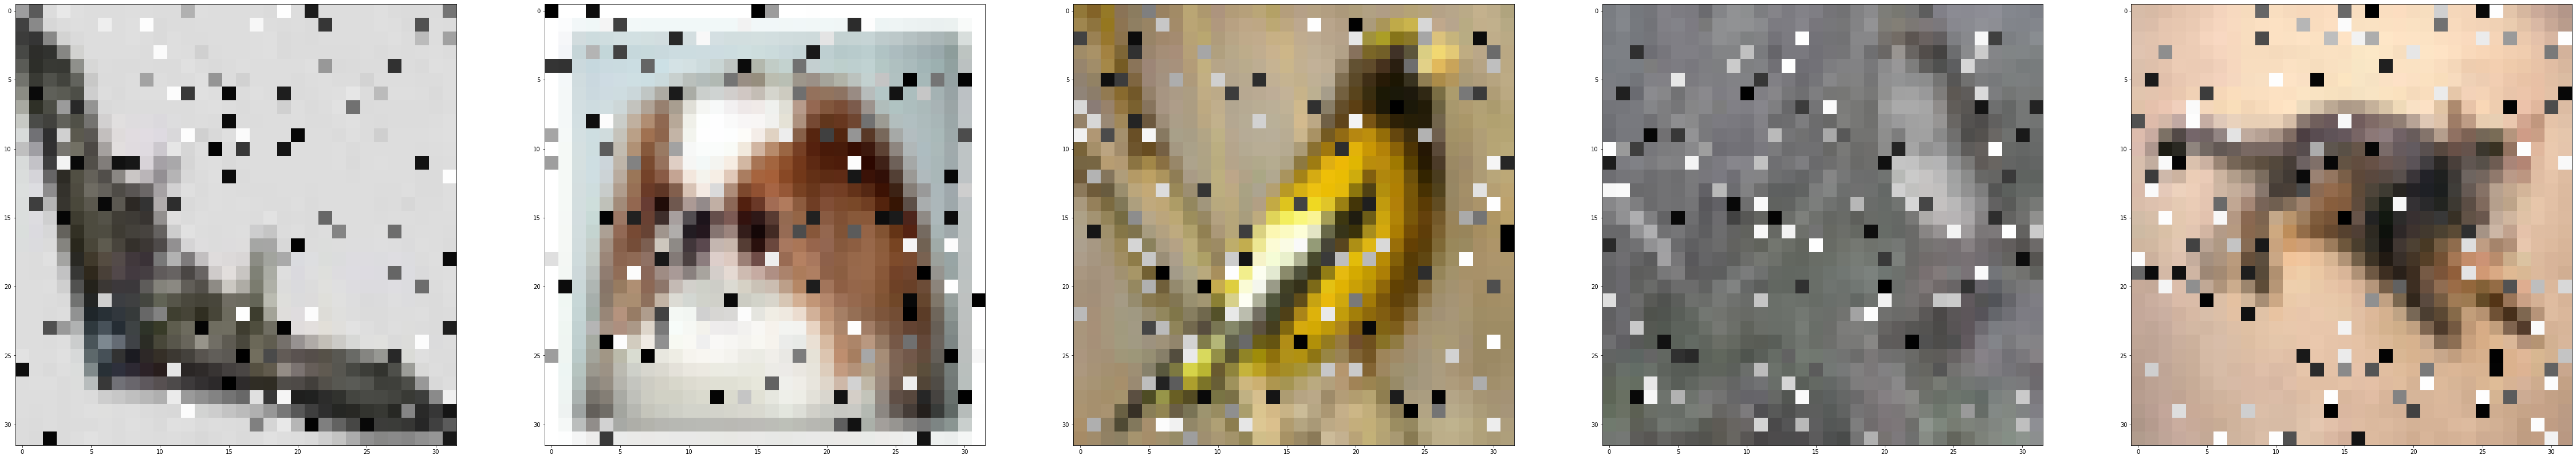

In [39]:
n = np.random.randint(0,len(val_x_n)-5)
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, :,0].reshape(32, 32, 3))
plt.show()

In [40]:
prediction = model.predict(val_x_n[n:n+5])
prediction.shape

(5, 32, 32, 3, 1)

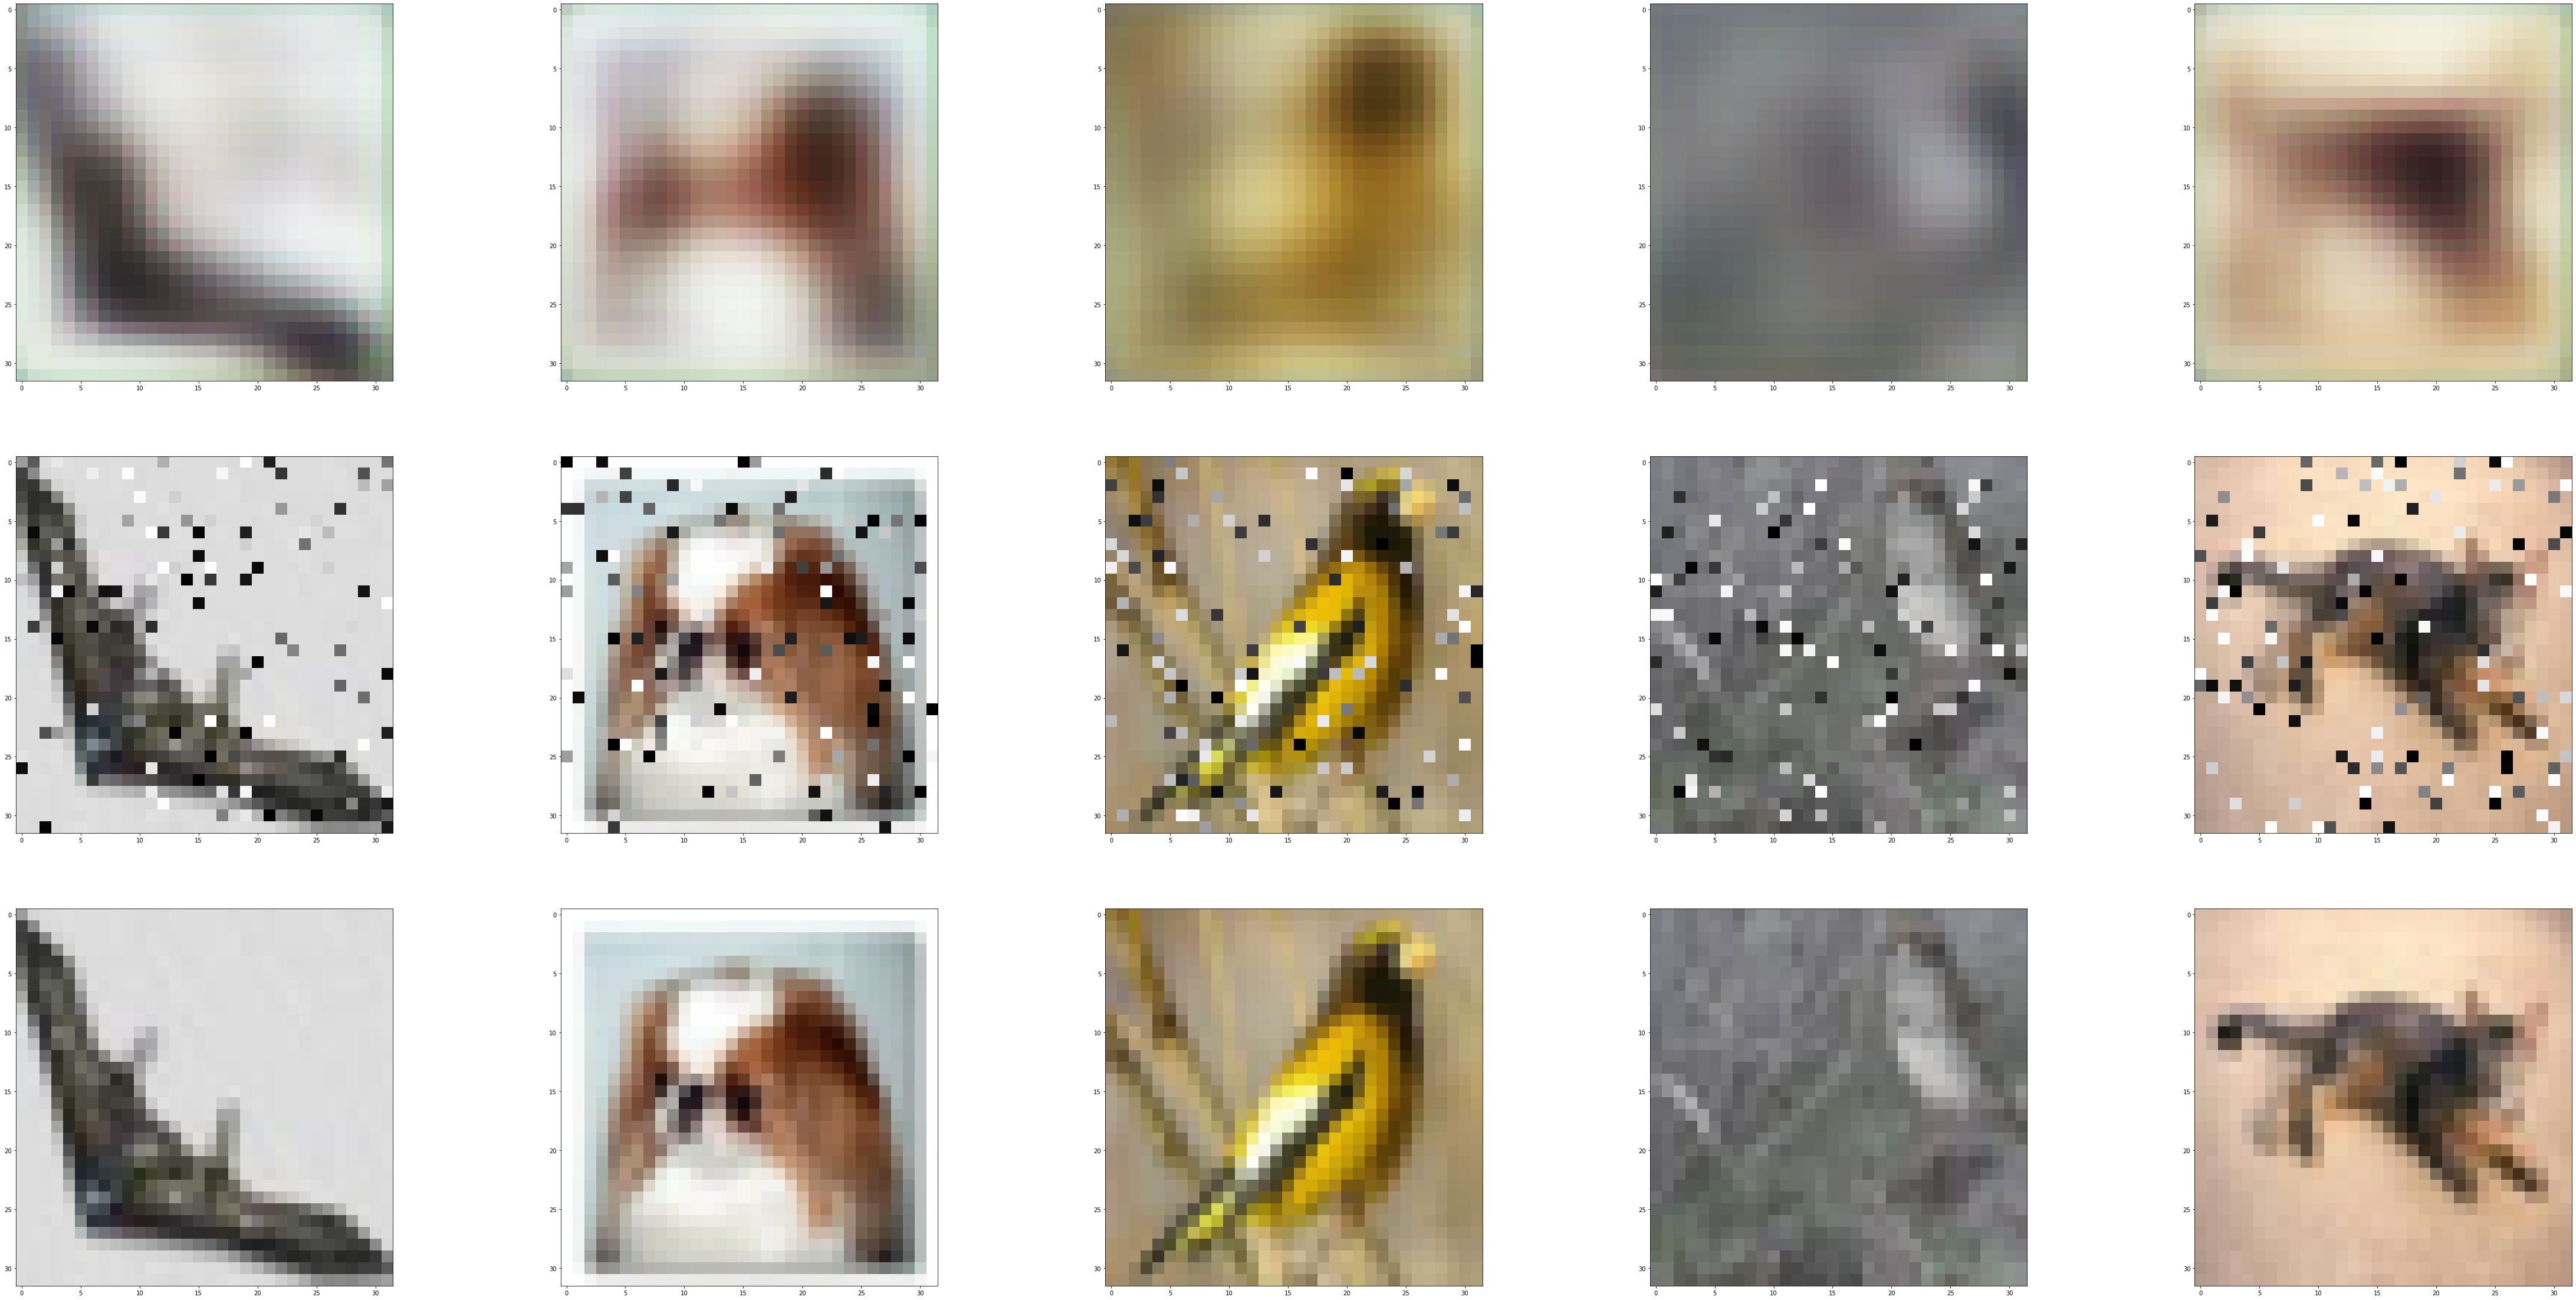

In [41]:
f, ax = plt.subplots(3,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(5)):
    ax[0,i].imshow(prediction[a, :, :, :,0].reshape(32, 32, 3))
    ax[1,i].imshow(val_x_n[n+i, :, :, :, 0].reshape(32, 32, 3))
    ax[2,i].imshow(x_val[n+i].reshape(32, 32, 3))
plt.show()

In [0]:
model_2 = Model(input_layer, latent)
model_2.compile(optimizer='adam', loss='mse')

In [43]:
preds = model_2.predict(val_x_n[n:n+5])
preds.shape

(5, 4, 4, 3, 64)

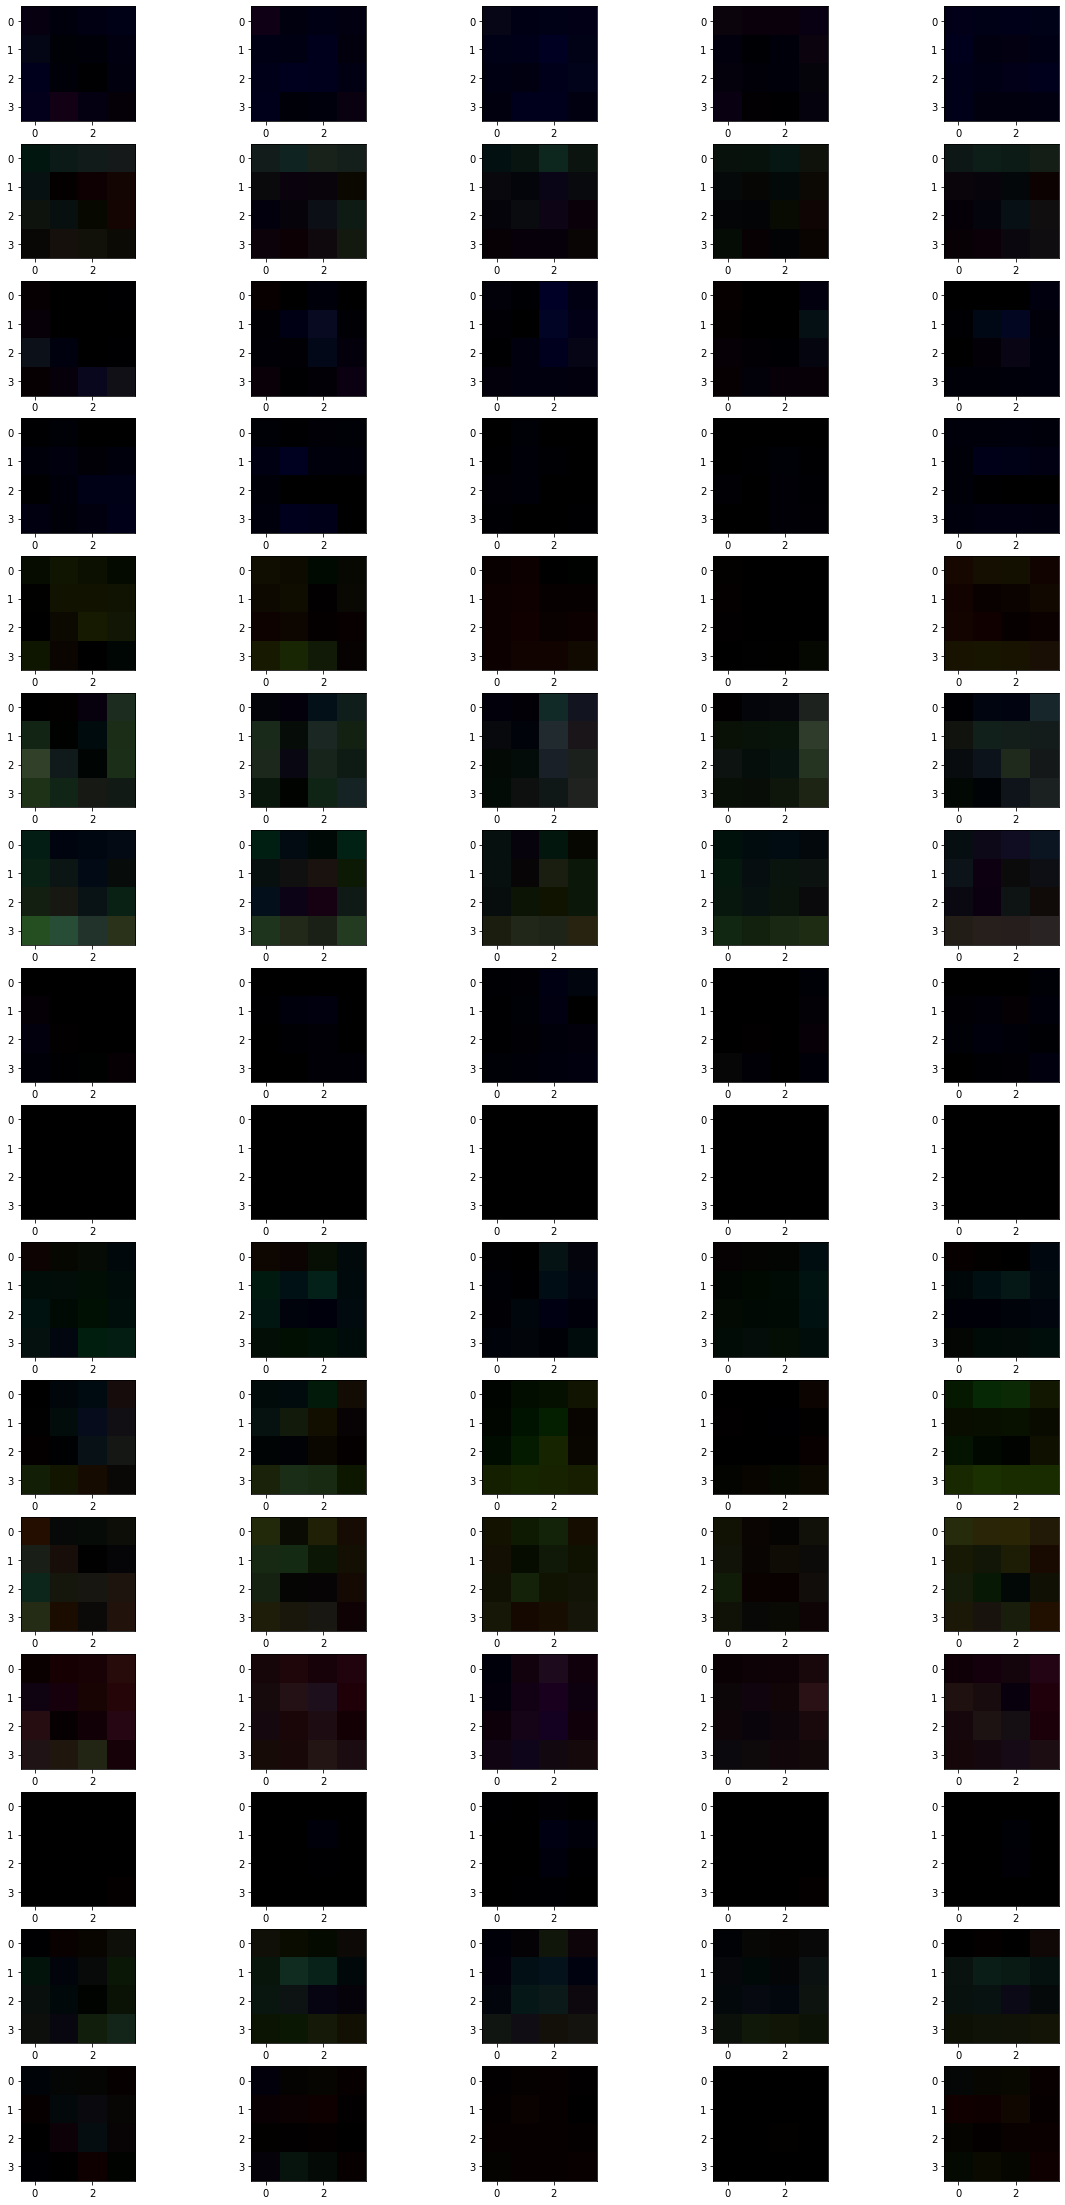

In [44]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(20, 40)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, :,j])
plt.show()

In [45]:
history = model.fit(train_x_n, x_train, epochs=1000, batch_size=2048, validation_data=(val_x_n, x_val), callbacks=[early_stopping])

Epoch 1/1000
25/25 [==============================] - 11s 449ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 2/1000
25/25 [==============================] - 11s 449ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 3/1000
25/25 [==============================] - 11s 450ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 4/1000
25/25 [==============================] - 11s 449ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 5/1000
25/25 [==============================] - 11s 451ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 6/1000
25/25 [==============================] - 11s 450ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 7/1000
25/25 [==============================] - 11s 450ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 8/1000
25/25 [==============================] - 11s 449ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 9/1000
25/25 [==============================] - 11s 450ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 10/1000
25/25 [==============================] - 11s 448ms/step - l

In [1]:
prediction = model.predict(val_x_n[n:n+5])
prediction.shape

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


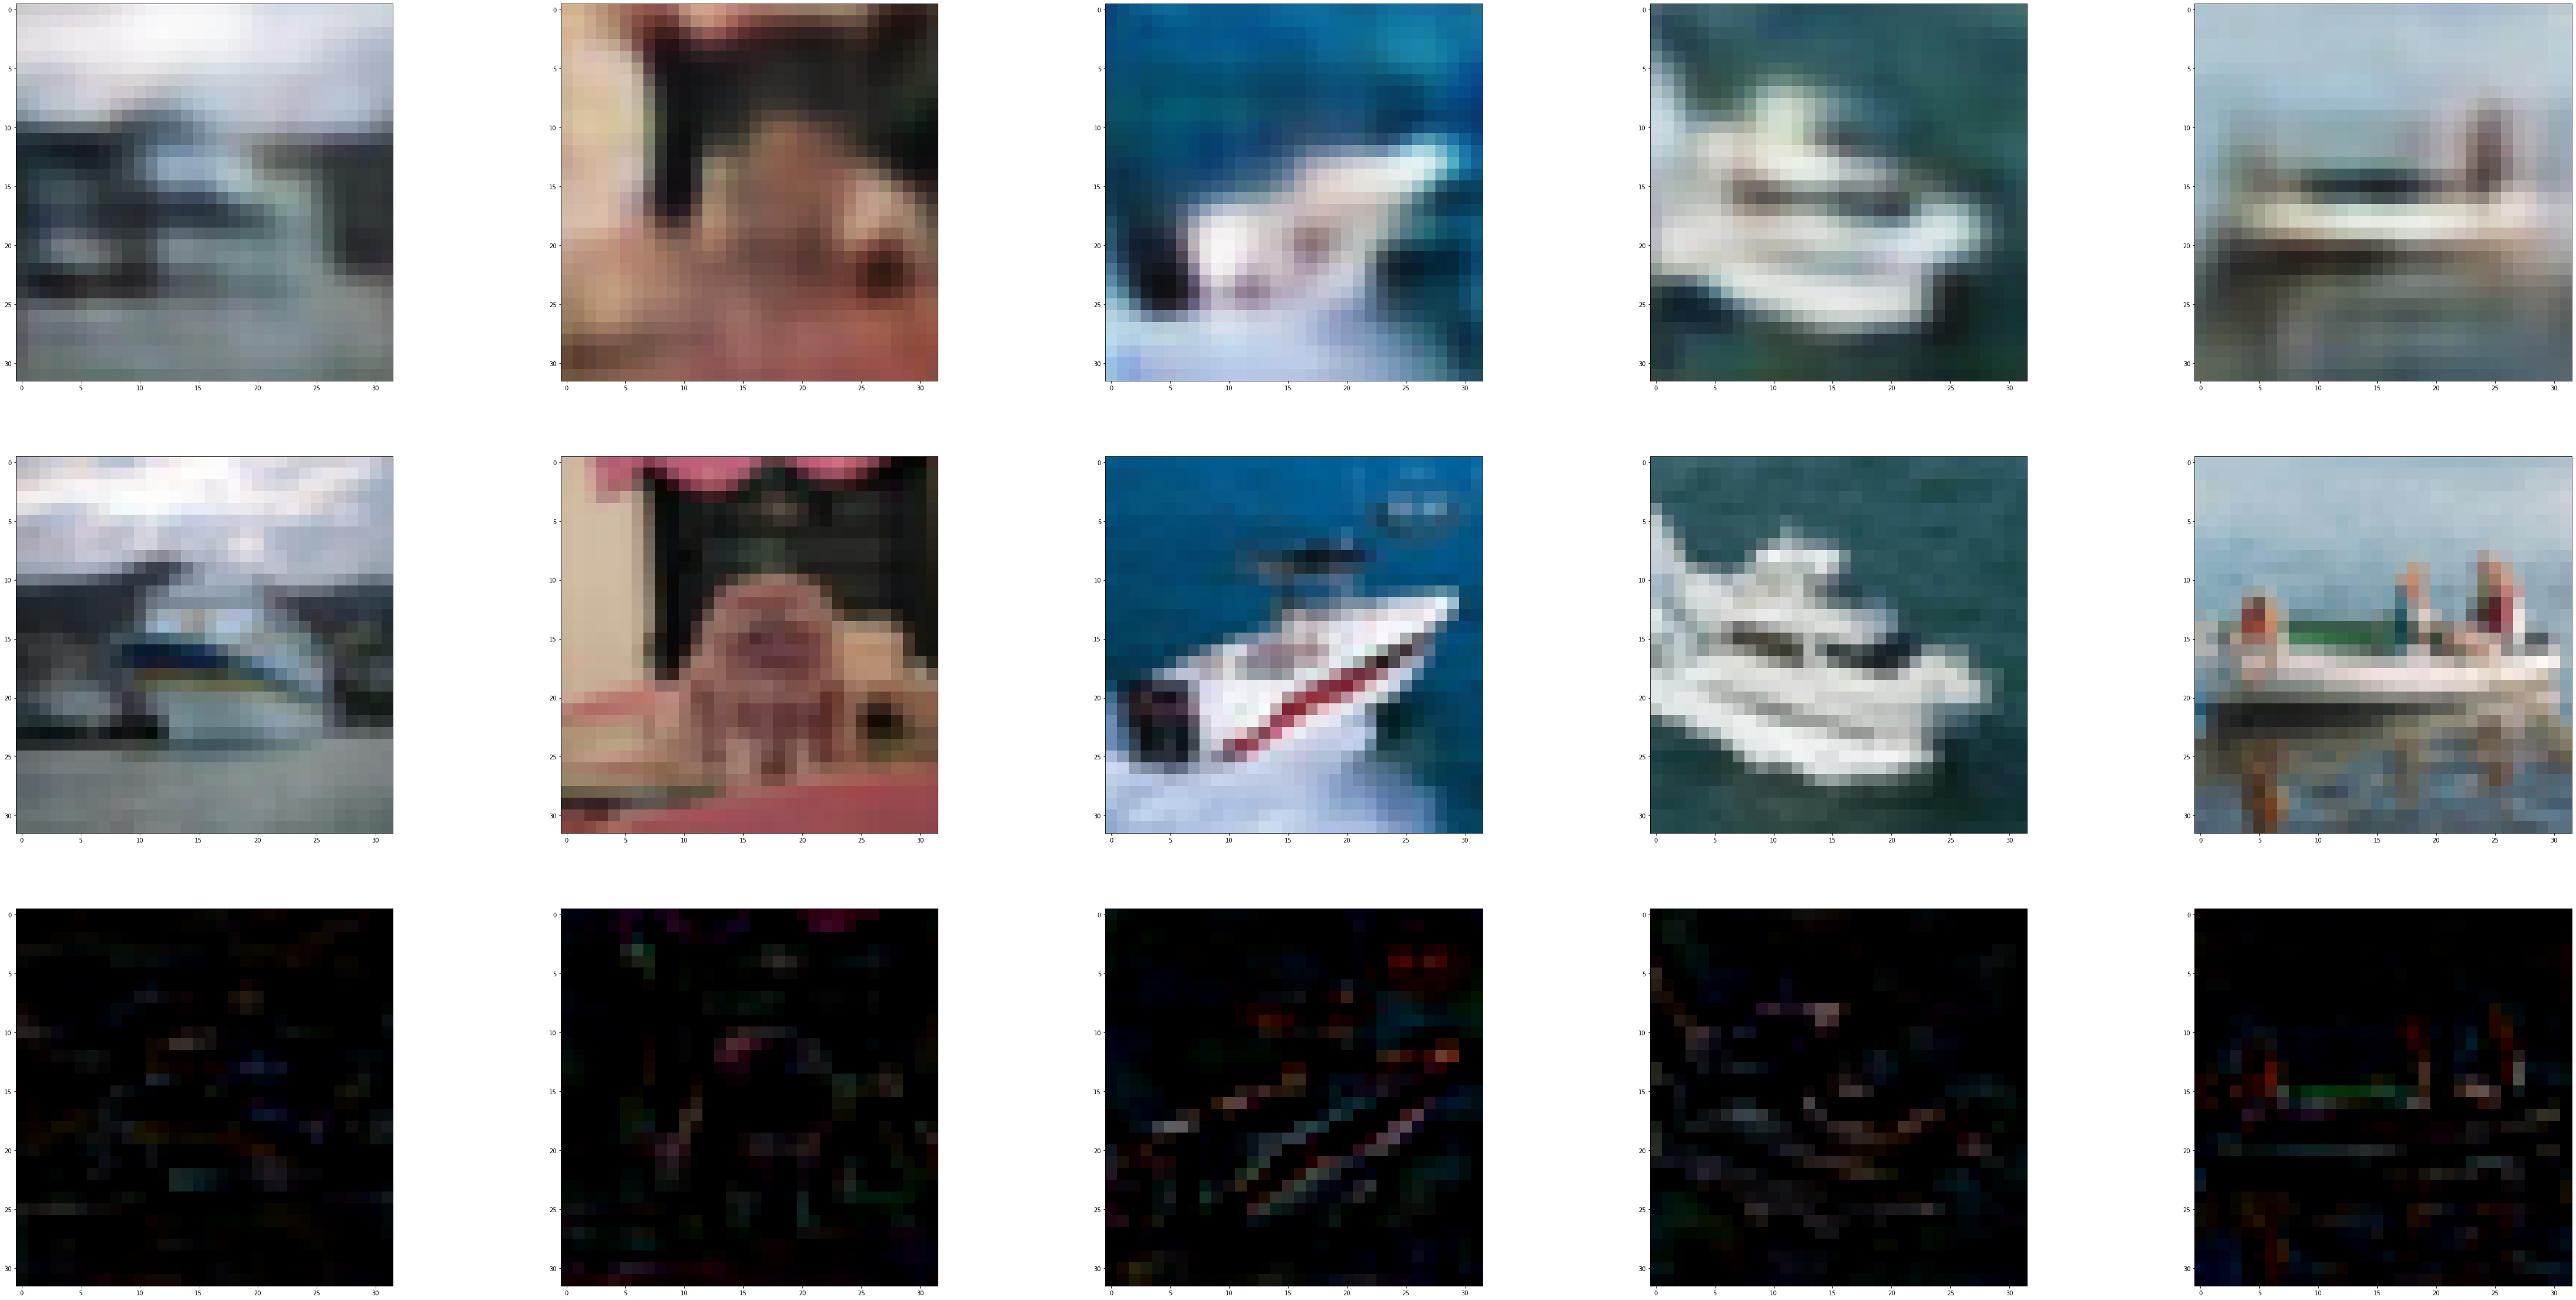

In [36]:
f, ax = plt.subplots(3,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(5)):
    ax[0,i].imshow(prediction[a, :, :, :,0].reshape(32, 32, 3))
    #ax[1,i].imshow(val_x_n[n+i, :, :, :, 0].reshape(32, 32, 3))
    ax[1,i].imshow(x_val[n+i].reshape(32, 32, 3))
    ax[2,i].imshow(x_val[n+i]-prediction[a, :, :, :,0])
plt.show()